In [3]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Video processing completed successfully


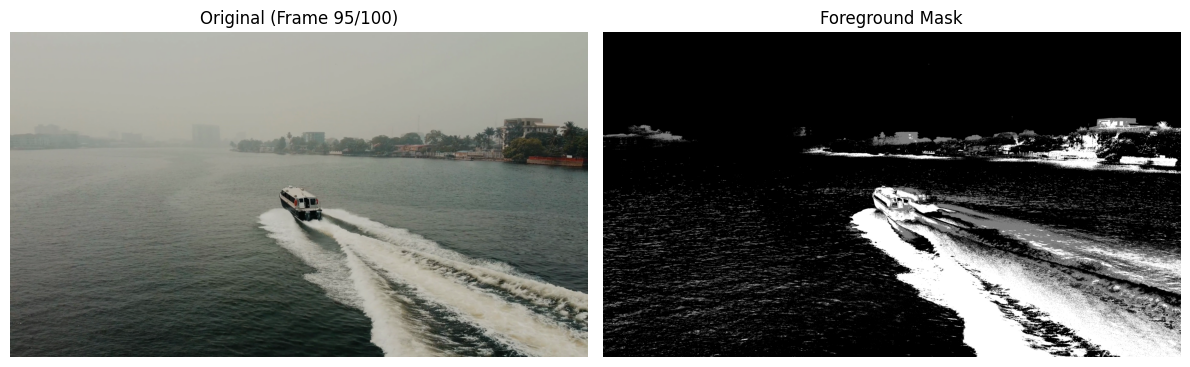

In [4]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import numpy as np
import time
from tqdm.notebook import tqdm

backSub = cv2.createBackgroundSubtractorKNN(history=500, dist2Threshold=400)

video_name = 'demo.mp4'
capture = cv2.VideoCapture(video_name)

if not capture.isOpened():
    print(f"Error: Could not open video file {video_name}")
else:
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = capture.get(cv2.CAP_PROP_FPS)

    max_frames = min(100, total_frames)

    print(f"Processing {max_frames} frames out of {total_frames} total frames")

    plt.figure(figsize=(12, 5))

    for frame_count in tqdm(range(max_frames)):
        ret, frame = capture.read()

        if not ret:
            print(f"End of video reached after {frame_count} frames")
            break

        mask = backSub.apply(frame)

        if frame_count % 5 == 0:
            clear_output(wait=True)

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f'Original (Frame {frame_count}/{max_frames})')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title('Foreground Mask')
            plt.axis('off')

            plt.tight_layout()
            display(plt.gcf())

    capture.release()
    cv2.destroyAllWindows()
    print("Video processing completed successfully")

In [13]:
def play_video(video_path, delay=25):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    window_name = "Processed Video"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

    print("Playing video. Press 'q' to quit, 'p' to pause/resume")

    paused = False
    while cap.isOpened():
        if not paused:
            ret, frame = cap.read()
            if not ret:
                break
            cv2.imshow(window_name, frame)

        key = cv2.waitKey(delay) & 0xFF

        if key == ord('q'):
            break
        elif key == ord('p'):
            paused = not paused

    cap.release()
    cv2.destroyAllWindows()
    print("Video playback finished")

In [14]:
from tqdm.notebook import tqdm

def create_background_subtracted_video(input_path, output_path, max_frames=100):
    cap = cv2.VideoCapture(input_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {input_path}")
        return None

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if max_frames is None:
        max_frames = total_frames
    else:
        max_frames = min(max_frames, total_frames)

    backSub = cv2.createBackgroundSubtractorKNN(history=500, dist2Threshold=400)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), False) # False for grayscale

    print(f"Processing {max_frames} frames and saving to {output_path}")

    for frame_count in tqdm(range(max_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        mask = backSub.apply(frame)

        out.write(mask)

    cap.release()
    out.release()
    print("Video processing completed successfully")
    return output_path


processed_video = create_background_subtracted_video(video_name, f"background_subtracted_{video_name}")
play_video(processed_video)

Processing 100 frames and saving to background_subtracted_demo.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

Video processing completed successfully
Playing video. Press 'q' to quit, 'p' to pause/resume
Video playback finished


In [17]:
import cv2

def process_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    _, thres = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    result_frame = frame.copy()

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(result_frame, (x, y), (x+w, y+h), (255, 0, 0), 3)

        cv2.drawContours(result_frame, [c], 0, (0, 0, 255), 2)

    return result_frame, thres

In [18]:
def create_contour_detected_video(video_path, output_path):
    capture = cv2.VideoCapture(video_path)

    if not capture.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = capture.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"Processing video: {video_path}")
    print("Press 'q' to quit, 'p' to pause/resume")

    paused = False
    while capture.isOpened():
        if not paused:
            ret, frame = capture.read()
            if not ret:
                break

            processed_frame, threshold = process_frame(frame)

            out.write(processed_frame)

            cv2.imshow("Original", frame)
            cv2.imshow("Contour Detection", processed_frame)
            cv2.imshow("Threshold", threshold)

        key = cv2.waitKey(5) & 0xFF

        if key == ord('q'):
            break
        elif key == ord('p'):
            paused = not paused
            print("Paused" if paused else "Resumed")

    capture.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processing complete. Output saved to {output_path}")

    print("Playing processed video")
    play_video(output_path)

In [19]:
## cntour in video
create_contour_detected_video(video_name, f"contour_detected_{video_name}")

Processing video: demo.mp4
Press 'q' to quit, 'p' to pause/resume
Processing complete. Output saved to contour_detected_demo.mp4
Playing processed video
Playing video. Press 'q' to quit, 'p' to pause/resume
Video playback finished
